<a href="https://colab.research.google.com/github/vyomaa/drowsy-driver-detection/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a CDC (center for disease control and prevention) survey, an estimated 1 in 25 adult drivers (aged 18 years or older) reported having fallen asleep while driving in the previous 30 days.

Drowsy driving was involved in 91,000 crashes in 2017—resulting in 50,000 injuries and nearly 800 deaths. In 2020, there were 633 deaths based on police reports. However, these numbers are underestimated, and over 6,000 fatal crashes each year may involve a drowsy driver.

A system to detect a driver's state of awareness/drowsiness is imperitive to prevention of such accidents and for saving lives.

The objective of our problem statement is to implement a deep learning model to accurately detect driver drowsiness using computer vision to analyze their facial expression and thus detect the signs of a drowsy driver (closed eyes, yawning) to an aware driver (open eyes, no yawn).

Here, I have designed a model that uses the LeNet architecture, a simple CNN model created by Yann LeCun, following which I have analyzed its accuracy and effectiveness in solving the problem.

The warning signs of drowsy driving:
1. Yawning or blinking frequently.
2. Trouble remembering the past few miles driven.
3. Missing your exit.
4. Drifting from your lane.
5. Hitting a rumble strip on the side of the road.

If a driver has any of these warning signs, it is imperitive to pull over to rest or let someone else drive. Simply turning up the radio or opening the window are not effective ways to keep one alert.

I start by importing the necessary libraries

In [ ]:
import numpy as np #for dealing with arrays
import pandas as pd #for dealing with dataset
import os #interact with operating system
import cv2 #computer vision
import matplotlib.pyplot as plt #showing images and accuracy graphs
import tensorflow #layers of the Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tensorflow.config.list_physical_devices('GPU')

[]

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dheerajperumandla/drowsiness-dataset

100% 161M/161M [00:06<00:00, 30.3MB/s]
100% 161M/161M [00:06<00:00, 24.6MB/s]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pwd

/content


In [ ]:
!unzip drowsiness-dataset.zip

Archive:  drowsiness-dataset.zip
  inflating: train/Closed/_0.jpg     
  inflating: train/Closed/_1.jpg     
  inflating: train/Closed/_10.jpg    
  inflating: train/Closed/_100.jpg   
  inflating: train/Closed/_101.jpg   
  inflating: train/Closed/_102.jpg   
  inflating: train/Closed/_103.jpg   
  inflating: train/Closed/_104.jpg   
  inflating: train/Closed/_105.jpg   
  inflating: train/Closed/_106.jpg   
  inflating: train/Closed/_107.jpg   
  inflating: train/Closed/_108.jpg   
  inflating: train/Closed/_109.jpg   
  inflating: train/Closed/_11.jpg    
  inflating: train/Closed/_110.jpg   
  inflating: train/Closed/_111.jpg   
  inflating: train/Closed/_112.jpg   
  inflating: train/Closed/_113.jpg   
  inflating: train/Closed/_114.jpg   
  inflating: train/Closed/_115.jpg   
  inflating: train/Closed/_116.jpg   
  inflating: train/Closed/_117.jpg   
  inflating: train/Closed/_118.jpg   
  inflating: train/Closed/_119.jpg   
  inflating: train/Closed/_12.jpg    
  inflating: trai

In [ ]:
labels = os.listdir("train")
labels

['Closed', 'yawn', 'Open', 'no_yawn']

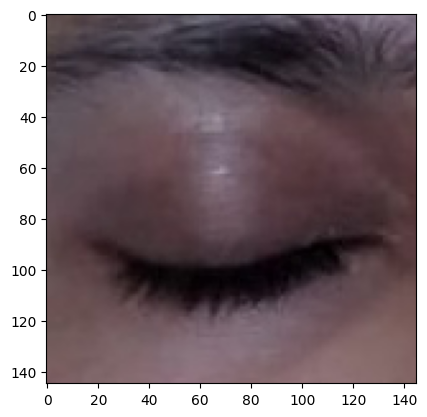

In [ ]:
plt.imshow(plt.imread("train/Closed/_0.jpg"))

In [ ]:
a = plt.imread("train/yawn/10.jpg")
a.shape

(480, 640, 3)

PREPROCESSING

a) Normalization

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2023-07-22 04:41:30--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2023-07-22 04:41:31 (16.1 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
def face_for_yawn(direc="train", face_cas_path="haarcascade_frontalface_default.xml"):
    yawn_no = []
    IMG_SIZE = 224
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yawn_no.append([resized_array, class_num1])
    return yawn_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="train/", face_cas="haarcascade_frontalface_default.xml", eye_cas="haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 224
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train = get_data()

2
3


In [ ]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [ ]:
new_data = append_data()

0
1
2
3


<ipython-input-16-3101b219d5dc>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 224, 224, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

b) Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

c) Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

DEEP LEARNING MODEL

1) LENET

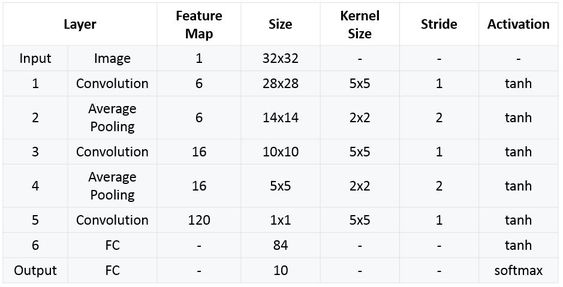

In [ ]:
modelLeNet = Sequential()

modelLeNet.add(Conv2D(6, (5, 5), activation="relu", input_shape=X_train.shape[1:]))
modelLeNet.add(MaxPooling2D(2, 2))

modelLeNet.add(Conv2D(16, (5, 5), activation="relu"))
modelLeNet.add(MaxPooling2D(2, 2))

modelLeNet.add(Flatten())
modelLeNet.add(Dropout(0.5))
modelLeNet.add(Dense(120, activation="relu"))
modelLeNet.add(Dense(84, activation="relu"))
modelLeNet.add(Dense(4, activation="softmax"))

modelLeNet.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

modelLeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dropout (Dropout)           (None, 44944)             0

In [ ]:
history = modelLeNet.fit(train_generator, epochs=20, validation_data=test_generator, validation_steps=len(test_generator))

Epoch 1/20
43/43 [==============================] - 106s 2s/step - loss: 1.3735 - accuracy: 0.5122 - val_loss: 0.5351 - val_accuracy: 0.7855
Epoch 2/20
43/43 [==============================] - 98s 2s/step - loss: 0.4215 - accuracy: 0.8077 - val_loss: 0.3375 - val_accuracy: 0.8599
Epoch 3/20
43/43 [==============================] - 92s 2s/step - loss: 0.3094 - accuracy: 0.8686 - val_loss: 0.2435 - val_accuracy: 0.9118
Epoch 4/20
43/43 [==============================] - 102s 2s/step - loss: 0.2902 - accuracy: 0.8790 - val_loss: 0.2687 - val_accuracy: 0.8806
Epoch 5/20
43/43 [==============================] - 92s 2s/step - loss: 0.3016 - accuracy: 0.8686 - val_loss: 0.2771 - val_accuracy: 0.8927
Epoch 6/20
43/43 [==============================] - 91s 2s/step - loss: 0.2899 - accuracy: 0.8782 - val_loss: 0.2240 - val_accuracy: 0.9291
Epoch 7/20
43/43 [==============================] - 90s 2s/step - loss: 0.2498 - accuracy: 0.8894 - val_loss: 0.2014 - val_accuracy: 0.9273
Epoch 8/20
43/43 [

PERFORMANCE MEASURES

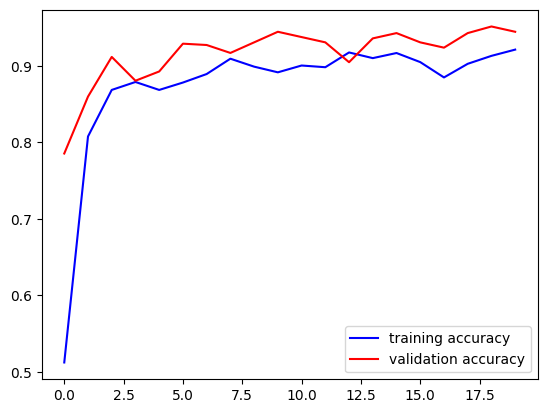

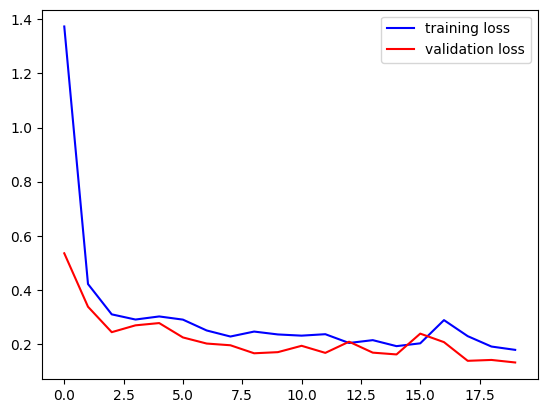

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
modelLeNet.save("drowiness_new6.h5")
modelLeNet.save("drowiness_new6.model")

As shown, the LeNet model has given an training accuracy of 92.13% and a testing or validation accuracy of 94.46%.

These results have been represented in graphical form as the accuracy improves over each epoch.


---

Accuracy Comparison of Drowsiness Detection Methods

Authors  | Method | Results
-------------------|------------------|---------------
[1] GWAK ET AL.      | ENSEMBLE MACHINE LEARNING     | 65.2 %
[2] JABBAR ET AL.      | CNN     | 83.33 %
[3] MEHTA ET AL. | EYE ASPECT RATIO AND EYE CLOSURE RATIO | 84 %
[4] KEPESIOVA ET AL. | CONV GRNN, CNN | 84.41 %
[5] DUA ET AL. | ALEXNET, VGG-FACENET, FLOWIMAGENET, RESNET | 85 %
[6] AYTEKIN ET AL. | TRANSFER LEARNING VGG16 | 91 %
PROPOSED METHOD | LeNet | 94.46 %

References
[1] J. Gwak, A. Hirao, and M. Shino, “An investigation of early detection of driver drowsiness using ensemble machine learning based on hybrid sensing”,  Appl. Sci.,  vol.  10, no. 8,  Apr.  2020, Art no. 2890. https://doi.org/10.3390/app10082890

[2] R. Jabbar, M. Shinoy, M. Kharbeche, K. Al-Khalifa, M. Krichen, and K. Barkaoui, “Driver drowsiness detection model using convolutional neural networks techniques for android application”, in Proceedings of the 2020 IEEE  International  Conference  on  Informatics,  IoT,  and  Enabling Technologies, Doha, Qatar, May 2020, pp. 2–5. https://doi.org/10.1109/ICIoT48696.2020.9089484  

[3] S. Mehta, S. Dadhich, S. Gumber,  and A. J. Bhatt, “Real-time driver drowsiness detection system using eye aspect ratio and eye closure ratio”, in Proceedings of international conference on sustainable computing in science,  technology  and  management  (SUSCOM), Jaipur,  India,  Feb. 2019. https://doi.org/10.2139/ssrn.3356401

[4] Z. Kepesiova, J. Ciganek,  and S. Kozak, “Driver drowsiness detection using convolutional neural networks”, in 2020 Cybernetics & Informatics (K&I),  Velke Karlovice, Czech Republic,  Mar. 2020, pp. 1–6. https://doi.org/10.1109/KI48306.2020.9039851

[5] M. Dua, R. Singla, S. Raj,  and A. Jangra, “Deep CNN models-based ensemble approach to driver drowsiness detection”, Neural Computing and Applications, vol. 33, no. 8, pp. 3155–3168, Jul. 2021.  https://doi.org/10.1007/s00521-020-05209-7

[6] Alper Aytekin, Vasfiye Mençik, "Detection of Driver Dynamics with VGG16 Model", in Applied Computer Systems 27(1):83-88, June 2022. http://dx.doi.org/10.2478/acss-2022-0009








Through this study, I have created a model for drowsy driver detection, however, since its real-time implementation is unlikely it is necessary to take steps to prevent drowsy driving before taking the wheel.

* Get enough sleep! Most adults need at least 7 hours of sleep a day, and teens need at least 8 hours.
* Develop good sleeping habits, such as sticking to a sleep schedule.
* If you have a sleep disorder or have symptoms of a sleep disorder such as snoring or feeling sleepy during the day, talk to your doctor about treatment options.
* Before you drive, avoid taking medicines that make you sleepy. Be sure to check the label on any medicines you take or talk to your pharmacist.
* Before you drive, avoid drinking alcohol. Alcohol impairs the skills needed for driving and increases drowsiness.

PREDICTION

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"] #0,1,2,3
IMG_SIZE = 224
def prepare(filepath, face_cas="haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tensorflow.keras.models.load_model("./drowiness_new6.h5")

In [ ]:
prediction = model.predict([prepare("train/no_yawn/56.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 53ms/step


3

In [ ]:
prediction = model.predict([prepare("train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 69ms/step


2

In [ ]:
prediction = model.predict([prepare("train/Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 44ms/step


3

In [ ]:
prediction = model.predict([prepare("train/yawn/113.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 44ms/step


3